# Avaliação 3 - Questão 1

Encontre a função de resposta em frequência do sistema cuja equação de movimento é dada por: 

$ m\ddot{x} + d\dot{x} + k(x + x^3) = F sin(\omega t) $ \\

Mostre que o sistema pode ser considerado linear para pequenas amplitudes de vibração e que os fenômenos de stiffening e jump aparecem para amplitudes de vibração maiores.

Inicialmente, vamos obter as respostas para uma entrada com baixa amplitude ($0.1$ N) e para uma entrada com alta amplitude ($\sqrt{2}$ N) de excitação. Esses valores foram estipulados com base em testes prévios para verificar a ocorrência do salto. Para tanto, será feita uma varredura em frequência, e para cada valor de frequência, uma série temporal será calculada por integração numérica. Para plotar a resposta em função da frequência, tomar-se-á o regime permanente de cada série temporal (aqui considerado 120 segundos após testes prévios) em cada frequência como aproximação $x(t) = X sin(\omega t)$, onde cada $X$ será um ponto no gráfico amplitude ($X$) por frequência de excitação. Esse processo é também conhecido por varredura em frequência em regime permanente ou *stepped sine test*.

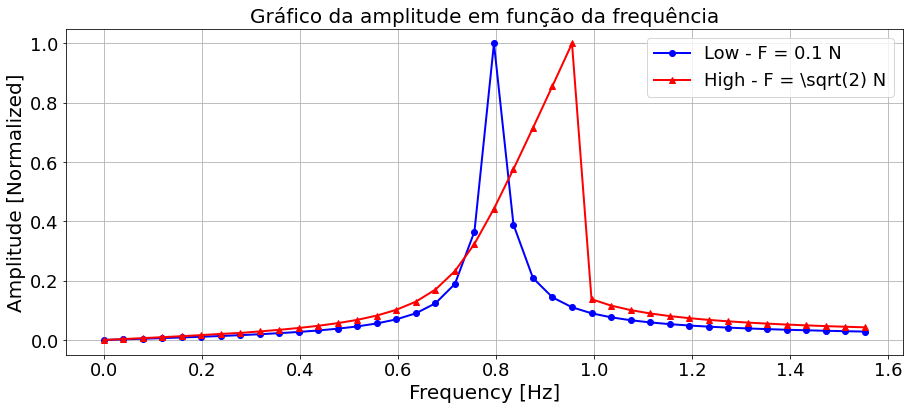

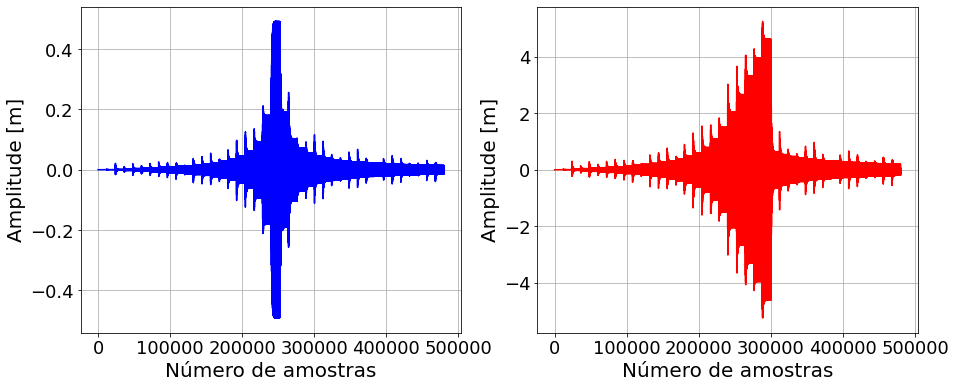

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
from scipy.integrate import odeint
from scipy.signal import hilbert, chirp

# Função que será integrada (aqui em espaço de estados)
def derivs(y, t, m, c, k, knl, Y, w):
  z1, z2 = y

  dydt = [ z2, (Y*np.sin(w*t)-(c)*z2-(k)*(z1)-knl*z1**3)/m]

  return dydt

# Condições iniciais:
y0_low = [0, 0] # [dx, x]
y0_high = [0, 0] # [dx, x]

# Incremento temporal
dt = 0.01 # [s]

# Vetor tempo
ti = 0 # [s]
tf = 120 # [s]
t = np.arange(ti,tf,dt) # [s]

# Massa
m = 1 # [kg]

# Rigidez da mola
k = 25 # [N/m]

# Não linearidade
knl = 25 # [N/m^3]

# Amortecimento
c = 0.2 # [N.s/m]

# Amplitude da excitação
Y_low = 0.1 # [N]
Y_high = np.sqrt(2) # [N]

# Vetor de frequências
wi = 0 # Freq. inicial [rad/s]
wf = 10 # Freq final [rad/s]
dw = 0.25 # Incremento em frequência [rad/s]
w = np.arange(wi,wf,dw) # Vetor de frequências [rad/s]
w_hz = w/(2*np.pi) # Vetor de frequências [Hz]

A_low = np.zeros(len(w))
A_high = np.zeros(len(w))
x_low = []
x_high = []

# Solução da EDO:
for i in range(0,len(w)):
  # Para baixa amplitude de excitação
  sol = odeint(derivs, y0_low, t, args=(m, c, k, knl, Y_low, w[i]))
  y0_low = [sol[-1,0], sol[-1,1]] # [dx, x] - redefinição das condições iniciais para garantir a continuidade do teste
  x_low.append(sol[:,1])
  A_low[i] = np.max(abs(sol[int(3*(len(t))/4):-1000,1])) # Tomando a amplitude da resposta no regime permanente

  # Para alta amplitude de excitação
  sol = odeint(derivs, y0_high, t, args=(m, c, k, knl, Y_high, w[i]))
  y0_high = [sol[-1,0], sol[-1,1]] # [dx, x] - redefinição das condições iniciais para garantir a continuidade do teste
  x_high.append(sol[:,1])
  A_high[i] = np.max(abs(sol[int(3*(len(t))/4):-1000,1])) # Tomando a amplitude da resposta no regime permanente

# Plot normalizado para comparação
plt.figure(figsize=(15,6))
plt.plot(w_hz,A_low/max(A_low),'b-o',linewidth=2,label='Low - F = 0.1 N')
plt.plot(w_hz,A_high/max(A_high),'r-^',linewidth=2,label='High - F = \sqrt(2) N')
plt.grid()
plt.title('Gráfico da amplitude em função da frequência',fontsize=20)
plt.xlabel('Frequency [Hz]',fontsize=20)
plt.ylabel('Amplitude [Normalized]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

x_low=np.asarray(x_low)
x_low=np.concatenate(x_low)
x_high=np.asarray(x_high)
x_high=np.concatenate(x_high)

plt.figure(figsize=(15,6))

# Plot da resposta temporal completa (para toda a faixa de frequências)
plt.subplot(1,2,1)
plt.plot(x_low,'b-')
plt.xlabel('Número de amostras',fontsize=20)
plt.ylabel('Amplitude [m]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.subplot(1,2,2)
plt.plot(x_high,'r-')
plt.xlabel('Número de amostras',fontsize=20)
plt.ylabel('Amplitude [m]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.show()

Para validar nosso cálculo, a resposta também foi obtida pela transformada de Hilbert. Não entraremos em detalhes aqui, mas o código abaixo mostra este processo, e na sequência tem-se a comparação da resposta obtida anteriormente, diretamente da resposta temporal, e aqui pela transformada de Hilbert.

In [0]:
# Calculando a resposta pela transformada de Hilbert

def frcurve(x,Np,Nsteps,Nwait):
  X = np.zeros((Nsteps,1))
  aux = 1
  for k in range(0,Nsteps):
    signal = x[aux+Nwait:(aux+Np-100)]
    X[k] = np.mean(abs(hilbert(signal)))
    aux = aux+Np
  return X

vfreq1 =  np.linspace(wi,wf,len(w));
Np = int(len(x_high)/len(w));
Nwait = 10;
Nsteps = int(len(w));

f_low = np.zeros((len(w),len(t)))
f_high = np.zeros((len(w),len(t)))

for j in range(0,len(w)):
  for i in range(0,len(t)):
    f_low[j,i] = Y_low*np.sin(w[j]*t[i])
    f_high[j,i] = Y_high*np.sin(w[j]*t[i])

f_low = np.concatenate(f_low)
f_high = np.concatenate(f_high) 


X_high = np.zeros(len(w),dtype=complex)
U_high = np.zeros(len(w),dtype=complex)
X_low = np.zeros(len(w),dtype=complex)
U_low = np.zeros(len(w),dtype=complex)

X_high = frcurve(x_high,Np,Nsteps,Nwait)
U_high = frcurve(f_high,Np,Nsteps,Nwait)
X_low = frcurve(x_low,Np,Nsteps,Nwait)
U_low = frcurve(f_low,Np,Nsteps,Nwait)

In [126]:
H_ni_low = np.zeros(len(X_low),dtype=complex)
H_ni_high = np.zeros(len(X_high),dtype=complex)

# Cálculo da FRF
for i in range(0,len(X_high)):
  H_ni_low[i] = X_low[i]/U_low[i]
  H_ni_high[i] = X_high[i]/U_high[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


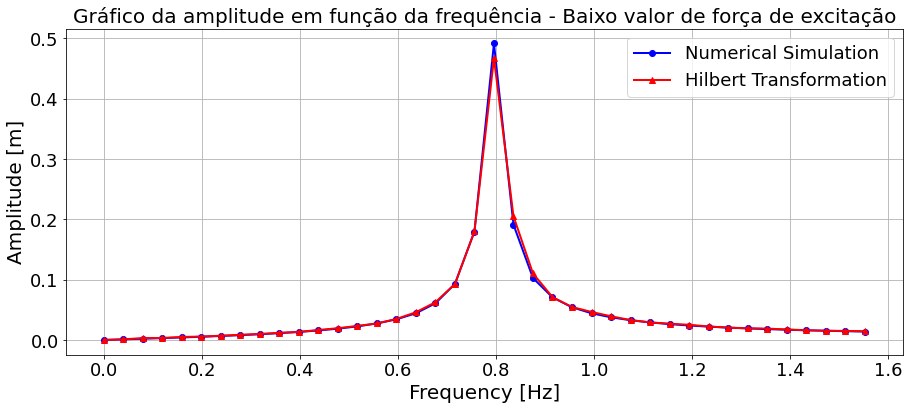

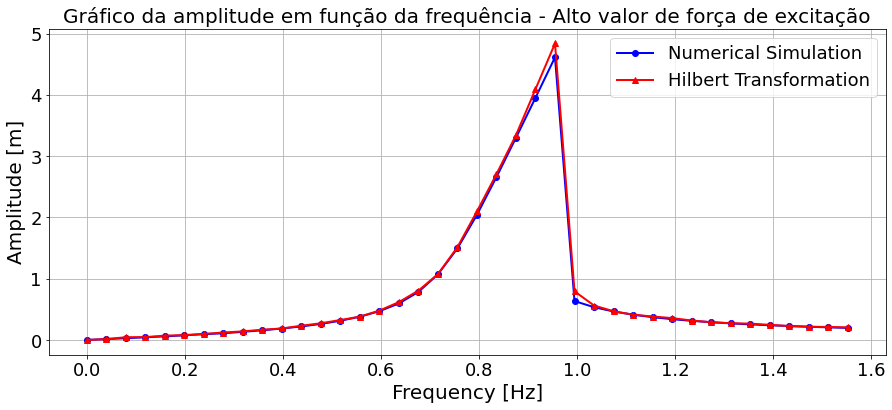

In [127]:
# Comparação das respostas
plt.figure(figsize=(15,6))
plt.plot(w_hz,A_low,'b-o',linewidth=2,label='Numerical Simulation')
plt.plot(w_hz,X_low,'r-^',linewidth=2,label='Hilbert Transformation')
plt.grid()
plt.title('Gráfico da amplitude em função da frequência - Baixo valor de força de excitação',fontsize=20)
plt.xlabel('Frequency [Hz]',fontsize=20)
plt.ylabel('Amplitude [m]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()


plt.figure(figsize=(15,6))
plt.plot(w_hz,A_high,'b-o',linewidth=2,label='Numerical Simulation')
plt.plot(w_hz,X_high,'r-^',linewidth=2,label='Hilbert Transformation')
plt.grid()
plt.title('Gráfico da amplitude em função da frequência - Alto valor de força de excitação',fontsize=20)
plt.xlabel('Frequency [Hz]',fontsize=20)
plt.ylabel('Amplitude [m]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()


Agora, iremos calcular a resposta pelo método do Balanço Harmônico (*Harmonic Balance Method* - HBM). O método do balanço harmônico propõe a aproximação do deslocamento $x(t)$ de um sistema por uma soma de termos harmônicos, tal como uma série de Fourier finita. Assim, tem-se pelo HBM:

$ x(t) = \mathcal{A}_0 + \sum_{n=1}^{N} (\mathcal{A}_n cos(n\omega t) + \mathcal{B}_n sin (n \omega t) = \mathcal{A}_0 + \sum_{n=1}^{N} \mathcal{X}_n sin (n \omega t + \phi_n) $ \\

sendo $\mathcal{A}_n, \mathcal{B}_n$ e $\mathcal{X}_n$ as amplitudes harmônicas, $n$ o índice que representa a razão da harmônica com relação à fundamental ($\omega$), e $N$ o número total de harmônicas consideradas na aproximação. Temos ainda:

$ \mathcal{X}_n = (\mathcal{A}_n^2 + \mathcal{B}_n ^2)^\dfrac{1}{2} $ \\

$ \phi_n = tan^{-1} \left( \dfrac{\mathcal{A}_n}{\mathcal{B}_n} \right) $ \\

O número de harmônicas consideradas interfere diretamente na precisão, porém a complexidade do processo de obtenção dos coeficientes também aumenta consideravelmente. Apesar disso, para muitas aplicações, principalmente envolvendo não linearidades suaves, a aproximação pela harmônica fundamental já é capaz de trazer bons resultados em certa faixa de frequência.
Ao se escolher uma aproximação, substitui-se na equação de movimento que descreve o sistema:

$ m \ddot{x} + \mathscr{F}(x, \dot{x}) = u $ \\

na qual $m$ representa a massa, $\ddot{x}$ a aceleração, $\dot{x}$ a velocidade, $x$ o deslocamento, $\mathscr{F}(x, \dot{x})$ a força de restauração do sistema (incluindo a parte não linear) e $u$ uma excitação externa. No geral, o HBM é aplicado considerando-se $u=Y sin(\omega t)$.

Uma possível continuação do método, muito popular para os casos em que a primeira harmônica já atinge resultados satisfatórios, é a aproximação da força de restauração por uma série de Fourier, e calcular seus coeficientes conforme a forma de análise clássica de Fourier. Para a implementação desta alternativa do método, admite-se que a força $\mathscr{F}(x, \dot{x})$ pode ser reescrita em termos de uma rigidez e um amortecimento equivalente:

$ \mathscr{F}(x, \dot{x}) = K_{eq}x + C_{eq}\dot{x}  $ \\

Adotando-se a aproximação fundamental do HBM, a equação resultante pode ser novamente comparada à expansão de Fourier:

$ \mathscr{F}(x, \dot{x}) = K_{eq}\mathcal{X}_1 (sin(\omega t)) + C_{eq}\omega \mathcal{X}_1(cos(\omega t)) = a_1 cos(\omega t) + b_1 sin (\omega t)  $ \\

sendo os coeficientes calculados por:

$ a_1 = \dfrac{\omega}{\pi} \int_{0}^{\dfrac{2\pi}{\omega}} \mathscr{F} (x, \dot{x}) cos(\omega t) dt$ \\

$ b_1 = \dfrac{\omega}{\pi} \int_{0}^{\dfrac{2\pi}{\omega}} \mathscr{F} (x, \dot{x}) sin(\omega t) dt$ \\

Vale lembrar que por se tratar de apenas uma harmônica, na qual o ângulo $\phi_1$ representa um defasamento do deslocamento $x(t)$ com relação à excitação $u(t)$, este ângulo
pode ser subtraído diretamente no termo de excitação, ao invés de incluído na resposta $x(t)$, simplificando as manipulações envolvendo a resposta. Nestes casos a excitação passa
a ser considerada $u(t) = Y sin(\omega t − \phi_1)$.

Ficamos assim com:

$ C_{eq} = \dfrac{a_1}{\omega \mathcal{X}_1} $ \\

$ K_{eq} = \dfrac{b_1}{\mathcal{X}_1} $ \\

Uma Função de Resposta em Frequência FRF linearizada pode ser obtida então no formato:

$ \mathcal{H} (\omega) = \dfrac{1}{-m \omega^2 + K_{eq} + i C_{eq} \omega} $ \\

com módulo:

$ \left|  \dfrac{\mathcal{X}_1}{Y} (\omega)  \right| = |\mathcal{H}(\omega)| = \dfrac{1}{\left((-m\omega^2 + K_{eq})^2+C_{eq}^2 \omega^2 \right)^{\dfrac{1}{2}}} $ \\

e ângulo de fase:

$ \phi_1 = tan^{-1} \left( \dfrac{-C_{eq} \omega}{-m\omega^2 + K_{eq}}  \right) $ \\

Vamos agora considerar nossa equação, que é um **oscilador de Duffing** simétrico, ou seja, não há termos quadráticos na não linearidade, somente cúbicos. Nossa força de restauração pode ser escrita:

 $ \mathscr{F} (x, \dot{x}) = k_1 x + k_3 x^3 + c \dot{x} $ \\

 Utilizando-se a primeira harmônica, e considerando $u(t) = Y sin(\omega t-\phi_1)$:

 $ \mathscr{F} (x, \dot{x}) \approx k_1 \mathcal{X}_1 sin(\omega t) + k_3(\mathcal{X}_1 sin(\omega t))^3 + c\omega \mathcal{X}_1 cos(\omega t) \approx a_1 cos(\omega t) + b_1 sin(\omega t) $ \\

 Das equações anteriores, do HBM:

 $ a_1 = \mathcal{X}_1 \omega c $ \\

 $ b_1 = \dfrac{3\mathcal{X}_1^3 k_3}{4} + \mathcal{X}_1 k_1$ \\

 E assim:

 $ C_{eq} = c $ \\

 $ K_{eq} = \dfrac{3\mathcal{X}_1^3 k_3}{4} + k_1 $ \\

 A FRF analítica do oscilador de Duffing simétrico, portanto, é dada por:

 $ \mathcal{H}(\omega) = \dfrac{1}{-m\omega^2 + \dfrac{3\mathcal{X}_1^3 k_3}{4} + k_1 + ic\omega} $ \\

 Com base nesta relação, tem-se:

 $ |\mathcal{X}_1| \left( \left(-m\omega^2 + \dfrac{3\mathcal{X}_1^3 k_3}{4} + k_1   \right)^2 + c^2\omega^2   \right)^{\dfrac{1}{2}} = |Y|  $ \\

 Elevando-se a igualdade ao quadrado, chega-se ao polinômio de ordem 6:

 $  \mathcal{X}_1^6 \left( \dfrac{9 k_3^2}{16} \right) + \mathcal{X}_1^4 \left( \dfrac{3k_1k_3 - 3k_3 m \omega^2}{2}  \right) + \mathcal{X}_1^2(m^2\omega^4 - 2k_1m\omega^2+c^2\omega^2+k_1^2) - Y^2 = 0 $ \\

 cujas raízes são as possíveis amplitudes $\mathcal{X}_1$ para determinada frequência.

 Um fato interessante de ser mencionado é que, para baixa amplitude de excitação, na expressão da FRF

  $ \mathcal{H}(\omega) = \dfrac{1}{-m\omega^2 + \dfrac{3\mathcal{X}_1^3 k_3}{4} + k_1 + ic\omega} $ \\

  o termo $\mathcal{X}_1^3$ pode ser ignorado, uma vez que a amplitude de resposta é baixa, o que nos leva à expressão da FRF clássica linear, sem a presença do componente não linear. Veremos, mais a frente, que isso pode ser comprovado.

In [0]:
import sympy as sym

# Cálculo da resposta por Harmonic Balance Method

# Cálculo do módulo
# Vetor de frequências
wi = 0 # Freq. inicial [rad/s]
wf = 10 # Freq final [rad/s]
dw = 0.01 # Incremento em frequência [rad/s]
w_hb = np.arange(wi,wf,dw) # Vetor de frequências [rad/s]
w_hz_hb = w_hb/(2*np.pi) # Vetor de frequências [Hz]
Y = Y_high
A = A_high

X1 = sym.Symbol('X1')
a = 0
b = 0
XX = np.zeros((6,len(w_hb)),dtype=complex)
X = np.zeros((6,len(w_hb)),dtype=complex)

for j in range(0,len(w_hb)):
    # Resolução do polinômio para cálculod as raízes (respostas)
    coefs = [(9/16)*knl**2,0,(3*k*knl-3*knl*m*w_hb[j]**2)/2,0,(m*m*(w_hb[j]**4)-2*k*m*(w_hb[j]**2)+c*c*(w_hb[j]**2)+k*k),0,-Y*Y]
    X[:,j] = np.roots(coefs)
    X[:,j] = np.asarray(X[:,j])
    for i in range(0,len(X)):
        if np.isreal(X[i][j]) == True:
            XX[a][b] = X[i][j]
            a = a+1
    if a>0:
        b = b+1
    a = 0

XX = abs(XX)

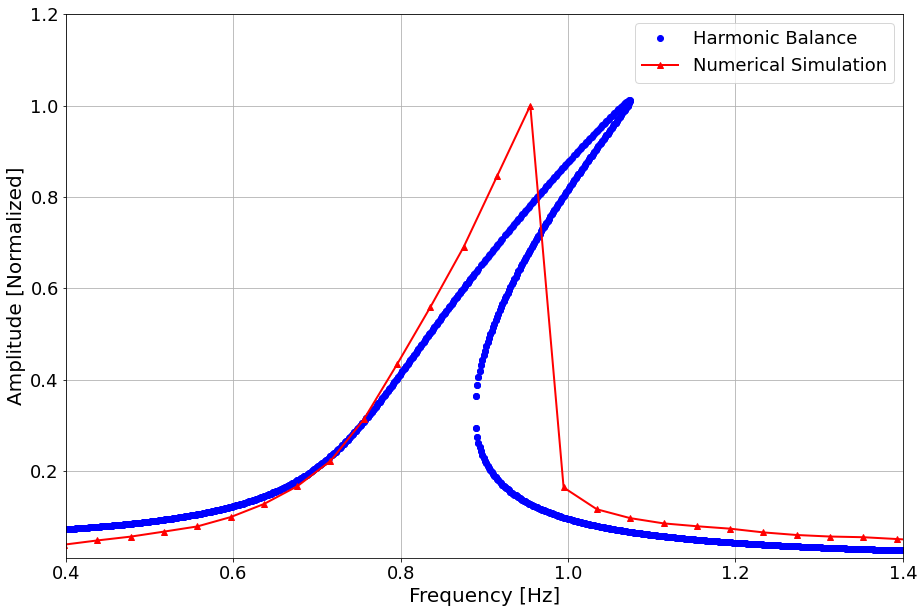

In [129]:
del X
X = np.zeros((6,len(w_hb)),dtype=complex)
for z in range(0,len(w_hb)):
    aux = np.unique(XX[:,z])
    X[0:len(aux),z] = aux

H = X/Y

# Comparação das respostas obtidas pelo HBM e obtidas diretamente da simulação numérica
plt.figure(figsize=(15,10))
for i in range(0,4):
  plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[i,:]))/np.max(abs(H[1,:])),'ob')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[-1,:]))/np.max(abs(H[1,:])),'ob',label='Harmonic Balance')
plt.plot(w_hz,abs(H_ni_high)/max(abs(H_ni_high[1:])),'r-^',linewidth=2,label='Numerical Simulation')
plt.xlabel('Frequency [Hz]',fontsize=20)
plt.ylabel('Amplitude [Normalized]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.ylim(0.01,1.2)
plt.xlim(0.4,1.4)
plt.legend(fontsize=18)
plt.show()


Pode-se perceber pela resposta que o HBM consegue captar a parte onde existe mais de uma solução (resposta) para o sistema, na região denominada salto (*backbone*). Nota-se também o fenômeno de *stiffening* ou *hardening*, que é, grosso modo, o *endurecimento de rigidez*, que pelo gráfico se dá pela modificação da frequência natural do sistema. É importante mencionar que estamos realizando a análise da resposta em regime não linear para ressaltar o fenômeno de *jump* e *stiffening*, mas à frente será mostrada a resposta para regime linear (com baixa amplitude de excitação).

Abaixo temos a resposta obtida por HBM onde cada cor representa uma solução diferente obtida pelo método (ao todo são seis), ou seja, contribuições na resposta final (total). Temos os gráficos de amplitude e fase.

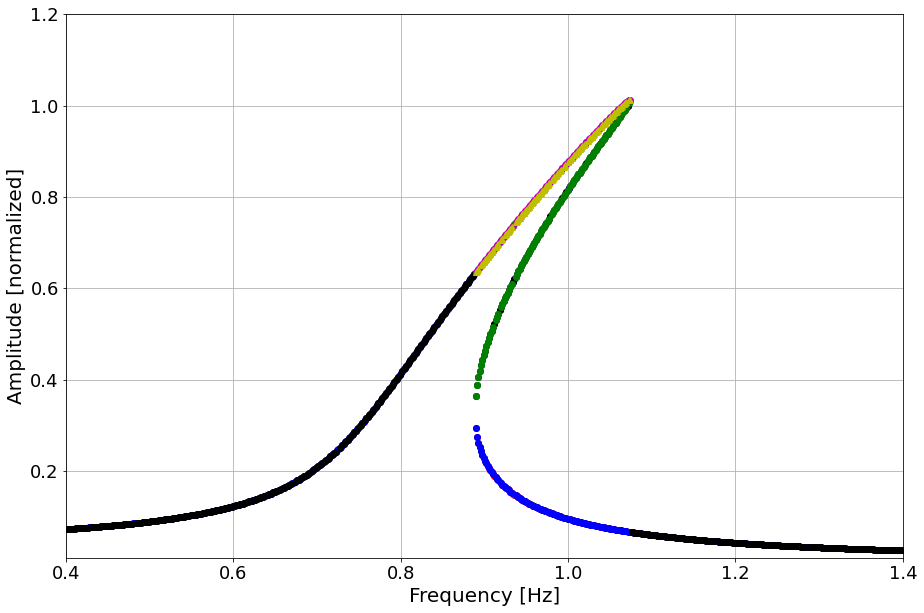

In [130]:
# Plot por partes da solução por balanço harmônico (respostas separadas)

plt.figure(figsize=(15,10))
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[0,:]))/np.max(abs(H[1,:])),'or')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[1,:]))/np.max(abs(H[1,:])),'ob')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[2,:]))/np.max(abs(H[1,:])),'ok')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[3,:]))/np.max(abs(H[1,:])),'og')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[4,:]))/np.max(abs(H[1,:])),'om')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[5,:]))/np.max(abs(H[1,:])),'^y')

plt.plot(w_hz,abs(H_ni_high)/np.max(abs(H_ni_high)),'r-^',linewidth=2)
plt.xlabel('Frequency [Hz]',fontsize=20)
plt.ylabel('Amplitude [normalized]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.ylim(0.01,1.2)
plt.xlim(0.4,1.4)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


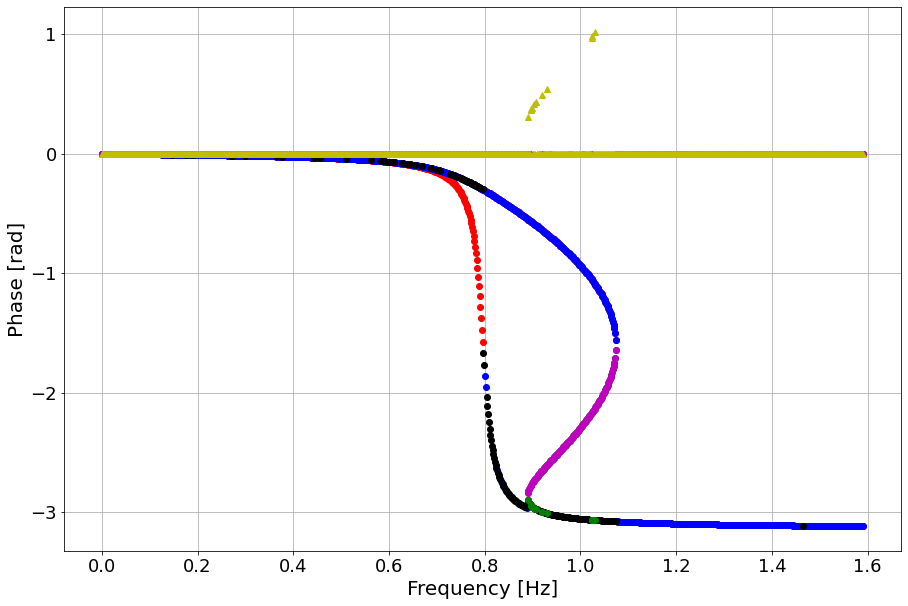

In [131]:
# Cálculo da fase
phi = np.zeros((len(XX),len(w_hb)))
for i in range(0,len(XX)):
  for j in range(0,len(w_hb)):
    phi[i][j] = np.arctan((-c*w_hb[j])/(-m*w_hb[j]**2+(3/4)*XX[i][j]**2*knl+k))

W = np.zeros((6,len(w_hb)))
for z in range (0,len(w_hb)):
    aux1 = np.unique(phi[:,z])
    W[0:len(aux1),z] = aux1

for l in range(0,len(w_hb)):
    for p in range(0,5):
        if W[p][l]>0:
            W[p][l]=W[p][l] - np.pi

plt.figure(figsize=(15,10))
plt.plot(np.transpose(w_hb)/(2*np.pi),W[0,:],'or')
plt.plot(np.transpose(w_hb)/(2*np.pi),W[1,:],'ob')
plt.plot(np.transpose(w_hb)/(2*np.pi),W[2,:],'ok')
plt.plot(np.transpose(w_hb)/(2*np.pi),W[3,:],'og')
plt.plot(np.transpose(w_hb)/(2*np.pi),W[4,:],'om')
plt.plot(np.transpose(w_hb)/(2*np.pi),W[5,:],'^y')
plt.xlabel('Frequency [Hz]',fontsize=20)
plt.ylabel('Phase [rad]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.show()

Nesta última seção, iremos comparar as respostas obtidas (i) pelo método do Balanço Harmônico, (ii) diretamente dos dados de simulação numérica e (iii) pela aproximação linear desconsiderando o termo $\mathcal{X}_1^3$ na resposta:

 $ \mathcal{H}(\omega) = \dfrac{1}{-m\omega^2 + \dfrac{3\mathcal{X}_1^3 k_3}{4} + k_1 + ic\omega} $ \\

 de onde teremos:

 
 $ \mathcal{H}(\omega) \approx \dfrac{1}{-m\omega^2 + k_1 + ic\omega} $ \\

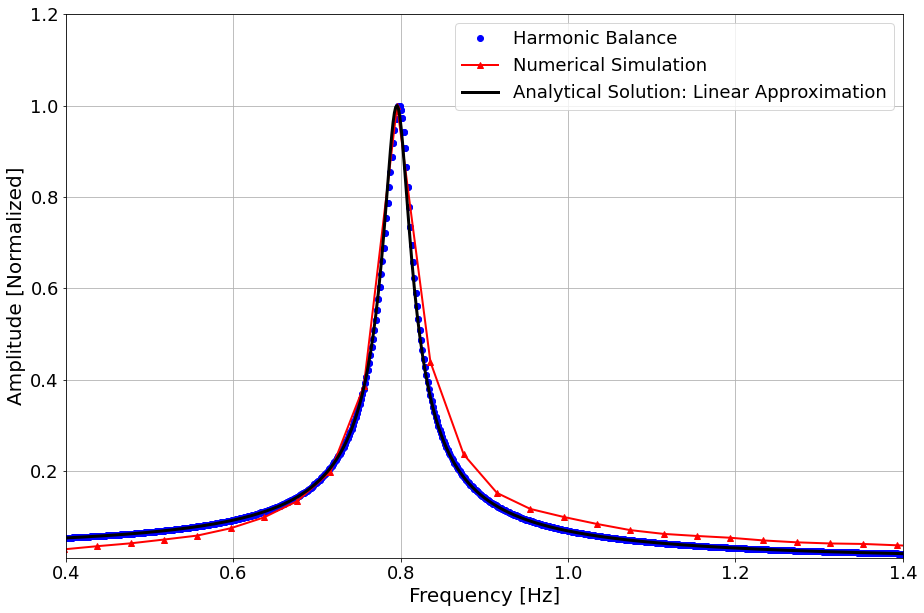

In [132]:
# Comparação entre a FRF obtida considerando um sistema linear e a FRF por balanço harmônico considerando força de excitação baixa

# Balanço Harmônico
Y = Y_low
A = A_low

X1 = sym.Symbol('X1')
a = 0
b = 0
XX = np.zeros((6,len(w_hb)),dtype=complex)
X = np.zeros((6,len(w_hb)),dtype=complex)

for j in range(0,len(w_hb)):
    coefs = [(9/16)*knl**2,0,(3*k*knl-3*knl*m*w_hb[j]**2)/2,0,(m*m*(w_hb[j]**4)-2*k*m*(w_hb[j]**2)+c*c*(w_hb[j]**2)+k*k),0,-Y*Y]
    X[:,j] = np.roots(coefs)
    X[:,j] = np.asarray(X[:,j])
    for i in range(0,len(X)):
        if np.isreal(X[i][j]) == True:
            XX[a][b] = X[i][j]
            a = a+1
    if a>0:
        b = b+1
    a = 0

XX = abs(XX)

del X
X = np.zeros((6,len(w_hb)),dtype=complex)
for z in range(0,len(w_hb)):
    aux = np.unique(XX[:,z])
    X[0:len(aux),z] = aux

H = X/Y

# FRF analítica considerando a aproximação linear (desprezando o termo cúbico)
H_ana = np.zeros(len(w_hb),dtype=complex)
for i in range(0,len(w_hb)):
  H_ana[i] = 1/(-m*w_hb[i]**2 + 1j*c*w_hb[i] + k)

plt.figure(figsize=(15,10))
for i in range(0,4):
  plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[i,:]))/np.max(abs(H[1,:])),'ob')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[-1,:]))/np.max(abs(H[1,:])),'ob',label='Harmonic Balance')
plt.plot(w_hz,abs(H_ni_low)/np.max(abs(H_ni_low[1:])),'r-^',linewidth=2,label='Numerical Simulation')
plt.plot(w_hz_hb,abs(H_ana)/max(abs(H_ana)),'k-',linewidth=3,label='Analytical Solution: Linear Approximation')
plt.xlabel('Frequency [Hz]',fontsize=20)
plt.ylabel('Amplitude [Normalized]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.ylim(0.01,1.2)
plt.xlim(0.4,1.4)
plt.legend(fontsize=18)
plt.show()


Nota-se que a aproximação é de fato válida, uma vez que as curvas praticamente se sobrepõem. Seria interessante utilizar alguma métrica para calcular o grau de proximidade das respostas.

Vamos agora analisar no domínio do tempo a aproximação linear em baixa e alta amplitude de excitação. Pelos gráficos obtidos, e que já era esperado, para baixa amplitude de excitação, o sistema pode ser aproximado por um sistema massa-mola-amortecedor, desprezando-se o termo cúbico, pois a amplitude de resposta é baixa. Já para a alta amplitude de excitação, temos grande divergência na aproximação (não só em amplitude, mas também em frequência), invalidando assim a linearidade.

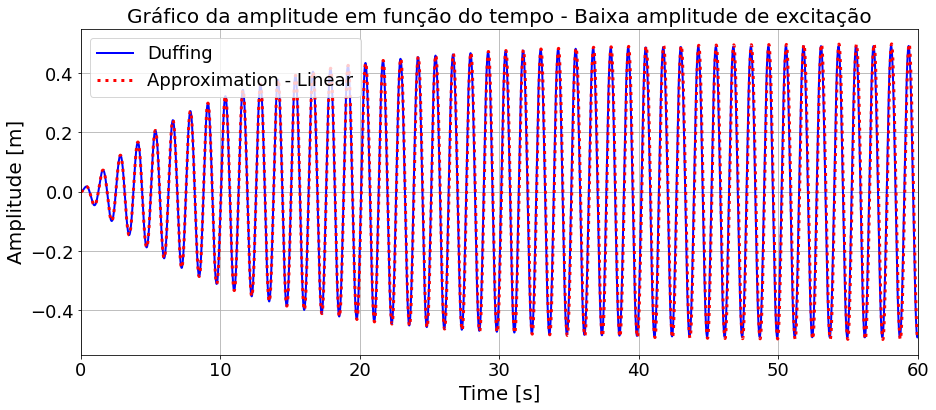

In [133]:
# Análise temporal - aproximaçao linear
# Vamos agora comparar a resposta temporal para o oscilador de Duffing e uma aproximação linear (desconsiderando o termo cúbico)
# Para tanto, iremos adotar baixa amplitude de força de excitação (0.1 N) e uma frequência de excitação de 5 rad/s

# Função que será integrada (aqui em espaço de estados)
def derivs_linear(y, t, m, c, k, Y, w):
  z1, z2 = y

  dydt = [ z2, (Y*np.sin(w*t)-(c)*z2-(k)*(z1))/m]

  return dydt

# Função que será integrada (aqui em espaço de estados)
def derivs(y, t, m, c, k, knl, Y, w):
  z1, z2 = y

  dydt = [ z2, (Y*np.sin(w*t)-(c)*z2-(k)*(z1)-knl*z1**3)/m]

  return dydt

# Condições iniciais:
y0_duffing = [0, 0] # [dx, x]
y0_approx = [0, 0] # [dx, x]

# Incremento temporal
dt = 0.01 # [s]

# Vetor tempo
ti = 0 # [s]
tf = 120 # [s]
t = np.arange(ti,tf,dt) # [s]

# Massa
m = 1 # [kg]

# Rigidez da mola
k = 25 # [N/m]

# Não linearidade
knl = 25 # [N/m^3]

# Amortecimento
c = 0.2 # [N.s/m]

# Amplitude da excitação
Y = 0.1 # [N]

# Frequência de excitação
w = 5 # [rad/s]

x_duffing = np.zeros(len(t))
x_linear = np.zeros(len(t))

# Solução da EDO:
# Para Duffing
sol = odeint(derivs, y0_duffing, t, args=(m, c, k, knl, Y, w))
x_duffing = sol[:,1]

# Para aproximação linear
sol = odeint(derivs_linear, y0_approx, t, args=(m, c, k, Y, w))
x_linear = sol[:,1]

# Plot normalizado para comparação
plt.figure(figsize=(15,6))
plt.plot(t, x_duffing,'b-',linewidth=2,label='Duffing')
plt.plot(t, x_linear,'r:',linewidth=3,label='Approximation - Linear')
plt.grid()
plt.title('Gráfico da amplitude em função do tempo - Baixa amplitude de excitação',fontsize=20)
plt.xlabel('Time [s]',fontsize=20)
plt.ylabel('Amplitude [m]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.xlim(0,60)
plt.show()


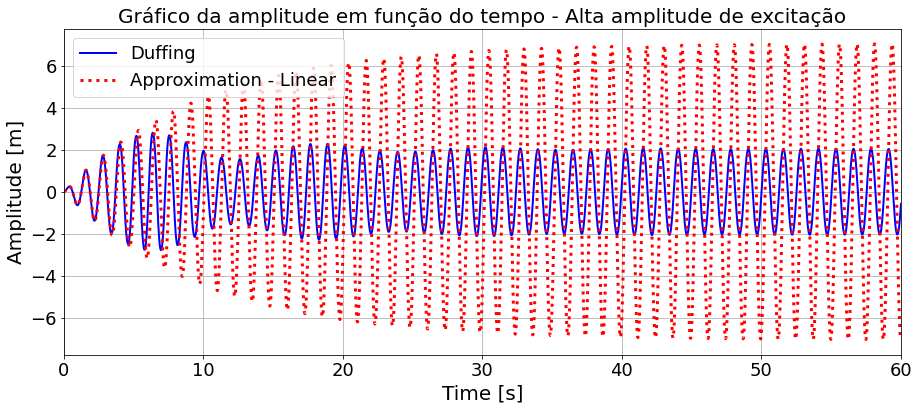

In [134]:
# Análise temporal - aproximaçao linear
# Vamos agora comparar a resposta temporal para o oscilador de Duffing e uma aproximação linear (desconsiderando o termo cúbico)
# Para tanto, iremos adotar alta amplitude de força de excitação (\sqrt(2) N) e uma frequência de excitação de 5 rad/s

# Função que será integrada (aqui em espaço de estados)
def derivs_linear(y, t, m, c, k, Y, w):
  z1, z2 = y

  dydt = [ z2, (Y*np.sin(w*t)-(c)*z2-(k)*(z1))/m]

  return dydt

# Função que será integrada (aqui em espaço de estados)
def derivs(y, t, m, c, k, knl, Y, w):
  z1, z2 = y

  dydt = [ z2, (Y*np.sin(w*t)-(c)*z2-(k)*(z1)-knl*z1**3)/m]

  return dydt

# Condições iniciais:
y0_duffing = [0, 0] # [dx, x]
y0_approx = [0, 0] # [dx, x]

# Incremento temporal
dt = 0.01 # [s]

# Vetor tempo
ti = 0 # [s]
tf = 120 # [s]
t = np.arange(ti,tf,dt) # [s]

# Massa
m = 1 # [kg]

# Rigidez da mola
k = 25 # [N/m]

# Não linearidade
knl = 25 # [N/m^3]

# Amortecimento
c = 0.2 # [N.s/m]

# Amplitude da excitação
Y = np.sqrt(2) # [N]

# Frequência de excitação
w = 5 # [rad/s]

x_duffing = np.zeros(len(t))
x_linear = np.zeros(len(t))

# Solução da EDO:
# Para Duffing
sol = odeint(derivs, y0_duffing, t, args=(m, c, k, knl, Y, w))
x_duffing = sol[:,1]

# Para aproximação linear
sol = odeint(derivs_linear, y0_approx, t, args=(m, c, k, Y, w))
x_linear = sol[:,1]

# Plot normalizado para comparação 
plt.figure(figsize=(15,6))
plt.plot(t, x_duffing,'b-',linewidth=2,label='Duffing')
plt.plot(t, x_linear,'r:',linewidth=3,label='Approximation - Linear')
plt.grid()
plt.title('Gráfico da amplitude em função do tempo - Alta amplitude de excitação',fontsize=20)
plt.xlabel('Time [s]',fontsize=20)
plt.ylabel('Amplitude [m]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.xlim(0,60)
plt.show()


Para finalizar a análise, como complemento, foi feito um teste com várias amplitudes de excitação, sendo elas $0.1$, $0.5$, $1$, $1.5$, $2$ e $4$ N. Os cálculos foram feitos utilizando o método do balanço harmônico, e plotou-se as respostas obtidas. Nota-se o efeito de *stiffening* quando da variação da frequência natural para a direita. Além disso, no gráfico tem-se esta evolução quantitativa de $0.8$ Hz para $1.6$ Hz quando da passagem da amplitude de excitação de $0.1$ para $2$ N.

In [0]:
import sympy as sym

# Cálculo da resposta por Harmonic Balance Method

# Cálculo do módulo
# Vetor de frequências
wi = 0 # Freq. inicial [rad/s]
wf = 10 # Freq final [rad/s]
dw = 0.01 # Incremento em frequência [rad/s]
w_hb = np.arange(wi,wf,dw) # Vetor de frequências [rad/s]
w_hz_hb = w_hb/(2*np.pi) # Vetor de frequências [Hz]
Y = np.array((0.1,0.5,1,1.5,2,4))

a = 0
b = 0
counta1 = 0
countb1 = 0
counta2 = 0
countb2 = 0
counta3 = 0
countb3 = 0
counta4 = 0
countb4 = 0
counta5 = 0
countb5 = 0

XX = np.zeros((6,len(w_hb)),dtype=complex)
X = np.zeros((6,len(w_hb)),dtype=complex)
XX1 = np.zeros((6,len(w_hb)),dtype=complex)
X1 = np.zeros((6,len(w_hb)),dtype=complex)
XX2 = np.zeros((6,len(w_hb)),dtype=complex)
X2 = np.zeros((6,len(w_hb)),dtype=complex)
XX3 = np.zeros((6,len(w_hb)),dtype=complex)
X3 = np.zeros((6,len(w_hb)),dtype=complex)
XX4 = np.zeros((6,len(w_hb)),dtype=complex)
X4 = np.zeros((6,len(w_hb)),dtype=complex)
XX5 = np.zeros((6,len(w_hb)),dtype=complex)
X5 = np.zeros((6,len(w_hb)),dtype=complex)

for j in range(0,len(w_hb)):
    # Resolução do polinômio para cálculo das raízes (respostas)
    coefs = [(9/16)*knl**2,0,(3*k*knl-3*knl*m*w_hb[j]**2)/2,0,(m*m*(w_hb[j]**4)-2*k*m*(w_hb[j]**2)+c*c*(w_hb[j]**2)+k*k),0,-Y[0]*Y[0]]
    X[:,j] = np.roots(coefs)
    X[:,j] = np.asarray(X[:,j])
    for i in range(0,len(X)):
        if np.isreal(X[i][j]) == True:
            XX[a][b] = X[i][j]
            a = a+1
    if a>0:
        b = b+1
    a = 0


    # Resolução do polinômio para cálculo das raízes (respostas)
    coefs = [(9/16)*knl**2,0,(3*k*knl-3*knl*m*w_hb[j]**2)/2,0,(m*m*(w_hb[j]**4)-2*k*m*(w_hb[j]**2)+c*c*(w_hb[j]**2)+k*k),0,-Y[1]*Y[1]]
    X1[:,j] = np.roots(coefs)
    X1[:,j] = np.asarray(X1[:,j])
    for i in range(0,len(X1)):
        if np.isreal(X1[i][j]) == True:
            XX1[counta1][countb1] = X1[i][j]
            counta1 = counta1+1
    if counta1>0:
        countb1 = countb1+1
    counta1 = 0

    # Resolução do polinômio para cálculo das raízes (respostas)
    coefs = [(9/16)*knl**2,0,(3*k*knl-3*knl*m*w_hb[j]**2)/2,0,(m*m*(w_hb[j]**4)-2*k*m*(w_hb[j]**2)+c*c*(w_hb[j]**2)+k*k),0,-Y[2]*Y[2]]
    X2[:,j] = np.roots(coefs)
    X2[:,j] = np.asarray(X2[:,j])
    for i in range(0,len(X2)):
        if np.isreal(X2[i][j]) == True:
            XX2[counta2][countb2] = X2[i][j]
            counta2 = counta2+1
    if counta2>0:
        countb2 = countb2+1
    counta2 = 0

    # Resolução do polinômio para cálculo das raízes (respostas)
    coefs = [(9/16)*knl**2,0,(3*k*knl-3*knl*m*w_hb[j]**2)/2,0,(m*m*(w_hb[j]**4)-2*k*m*(w_hb[j]**2)+c*c*(w_hb[j]**2)+k*k),0,-Y[3]*Y[3]]
    X3[:,j] = np.roots(coefs)
    X3[:,j] = np.asarray(X3[:,j])
    for i in range(0,len(X3)):
        if np.isreal(X3[i][j]) == True:
            XX3[counta3][countb3] = X3[i][j]
            counta3 = counta3+1
    if counta3>0:
        countb3 = countb3+1
    counta3 = 0


    # Resolução do polinômio para cálculo das raízes (respostas)
    coefs = [(9/16)*knl**2,0,(3*k*knl-3*knl*m*w_hb[j]**2)/2,0,(m*m*(w_hb[j]**4)-2*k*m*(w_hb[j]**2)+c*c*(w_hb[j]**2)+k*k),0,-Y[4]*Y[4]]
    X4[:,j] = np.roots(coefs)
    X4[:,j] = np.asarray(X4[:,j])
    for i in range(0,len(X4)):
        if np.isreal(X4[i][j]) == True:
            XX4[counta4][countb4] = X4[i][j]
            counta4 = counta4+1
    if counta4>0:
        countb4 = countb4+1
    counta4 = 0


    # Resolução do polinômio para cálculo das raízes (respostas)
    coefs = [(9/16)*knl**2,0,(3*k*knl-3*knl*m*w_hb[j]**2)/2,0,(m*m*(w_hb[j]**4)-2*k*m*(w_hb[j]**2)+c*c*(w_hb[j]**2)+k*k),0,-Y[5]*Y[5]]
    X5[:,j] = np.roots(coefs)
    X5[:,j] = np.asarray(X5[:,j])
    for i in range(0,len(X5)):
        if np.isreal(X5[i][j]) == True:
            XX5[counta5][countb5] = X5[i][j]
            counta5 = counta5+1
    if counta5>0:
        countb5 = countb5+1
    counta5 = 0


XX = abs(XX)
XX1 = abs(XX1)
XX2 = abs(XX2)
XX3 = abs(XX3)
XX4 = abs(XX4)
XX5 = abs(XX5)

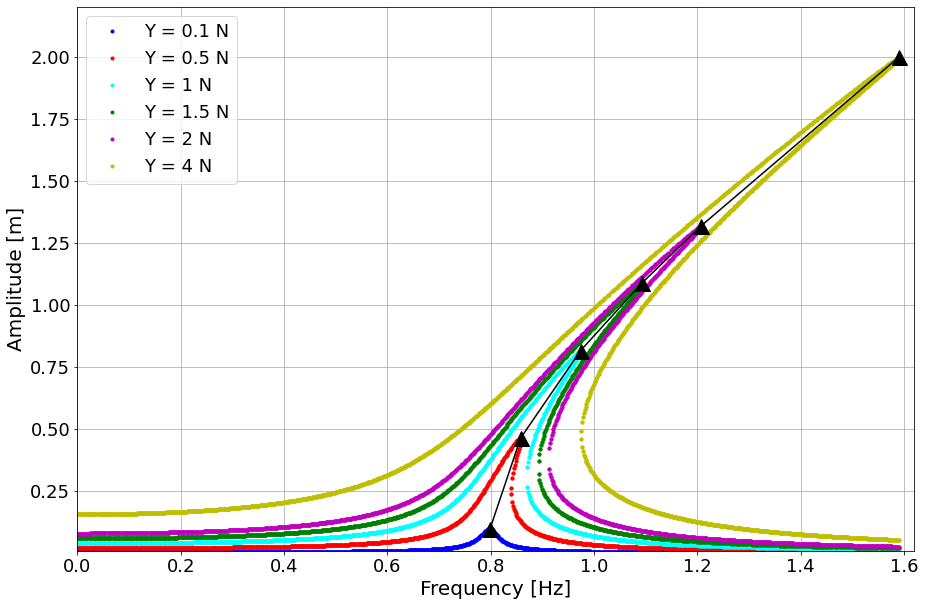

In [136]:
del X
del X1
del X2
del X3
del X4
del X5

X = np.zeros((6,len(w_hb)),dtype=complex)
X1 = np.zeros((6,len(w_hb)),dtype=complex)
X2 = np.zeros((6,len(w_hb)),dtype=complex)
X3 = np.zeros((6,len(w_hb)),dtype=complex)
X4 = np.zeros((6,len(w_hb)),dtype=complex)
X5 = np.zeros((6,len(w_hb)),dtype=complex)

for z in range(0,len(w_hb)):
    aux = np.unique(XX[:,z])
    X[0:len(aux),z] = aux

    aux1 = np.unique(XX1[:,z])
    X1[0:len(aux1),z] = aux1

    aux2 = np.unique(XX2[:,z])
    X2[0:len(aux2),z] = aux2

    aux3 = np.unique(XX3[:,z])
    X3[0:len(aux3),z] = aux3

    aux4 = np.unique(XX4[:,z])
    X4[0:len(aux4),z] = aux4

    aux5 = np.unique(XX5[:,z])
    X5[0:len(aux5),z] = aux5

H = X
H1 = X1
H2 = X2
H3 = X3
H4 = X4
H5 = X5

w_max = np.zeros(len(H))
amp_max = np.zeros(len(H))
aux_max = np.zeros(len(H))
resp=np.zeros((len(H),len(H[0])))

# Tomando valores para plotar o pico de cada resposta
for k in range(0,len(Y)):
  if k==0:
    resp=H
  elif k==1:
    resp=H1
  elif k==2:
    resp=H2
  elif k==3:
    resp=H3
  elif k==4:
    resp=H4
  else:
    resp=H5

  for i in range(0,len(resp)-1):
    aux_max[i] = max(abs(resp[i,:]))
    aux_max[i+1] = max(abs(resp[i+1,:]))
    if aux_max[i+1]>aux_max[i]:
      amp_max[k] = aux_max[i+1]

  for i in range(0,len(resp)):
    for j in range(0,len(resp[0])):
      if resp[i][j]==amp_max[k]:
        w_max[k] = w_hb[j]


# Comparação das respostas obtidas pelo HBM e obtidas diretamente da simulação numérica
plt.figure(figsize=(15,10))
for i in range(0,4):
  plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[i,:])),'.b')
  plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H1[i,:])),'.r')
  plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H2[i,:])),'.',color='cyan')
  plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H3[i,:])),'.g')
  plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H4[i,:])),'.m')
  plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H5[i,:])),'.y')

plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H[-1,:])),'.b',label='Y = 0.1 N')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H1[-1,:])),'.r',label='Y = 0.5 N')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H2[-1,:])),'.',color='cyan',label='Y = 1 N')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H3[-1,:])),'.g',label='Y = 1.5 N')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H4[-1,:])),'.m',label='Y = 2 N')
plt.plot(np.transpose(w_hb)/(2*np.pi),(abs(H5[-1,:])),'.y',label='Y = 4 N')

plt.plot(w_max/(2*np.pi),amp_max,'^-',markersize=15,color='black')

plt.xlabel('Frequency [Hz]',fontsize=20)
plt.ylabel('Amplitude [m]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.ylim(0.01,2.2)
plt.xlim(0,1.62)
plt.legend(fontsize=18)
plt.show()
